# Descriptor de HOG(Histogram of Oriented Gradients)

## importar librerías necesarias

In [1]:
! pip install tqdm

In [2]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import random
from SRC.hog import HOG
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

## Variables de entorno

In [3]:


carpeta_preprocesadas = 'data/preprocesadas/'
train_normal =carpeta_preprocesadas+'train/NORMAL/'
train_pneumonia =carpeta_preprocesadas+'train/PNEUMONIA/'
test_normal =carpeta_preprocesadas+'test/NORMAL/'
test_pneumonia =carpeta_preprocesadas+'test/PNEUMONIA/'
val_normal =carpeta_preprocesadas+'val/NORMAL/'
val_pneumonia =carpeta_preprocesadas+'val/PNEUMONIA/'
dir_train =carpeta_preprocesadas+'train/'
dir_test =carpeta_preprocesadas+'test/'
dir_val =carpeta_preprocesadas+'val/'
salida_caracteristicas = 'data/caracteristicas/hog/'

## Muestra aleatoria de las imágenes preprocesadas

Se tomara aleatoriamente 3 imagenes por clase del conjunto train


### Seleccion aleatoria de imágenes

In [4]:
#display 2x3 con 3 imagenes al azar de nuemonia y 3 de normal del set de train

# Seleccionar 3 imágenes al azar de cada categoría  
normal_images = os.listdir(train_normal)
neumonia_images = os.listdir(train_pneumonia)
random_normal_images = random.sample(normal_images, 3)
random_neumonia_images = random.sample(neumonia_images, 3)

cell_size = (8, 8)
block_size = (16, 16)
block_stride = (8, 8)
num_bins = 9





### cargar y mostrar imágenes aleatoriamente seleccionadas

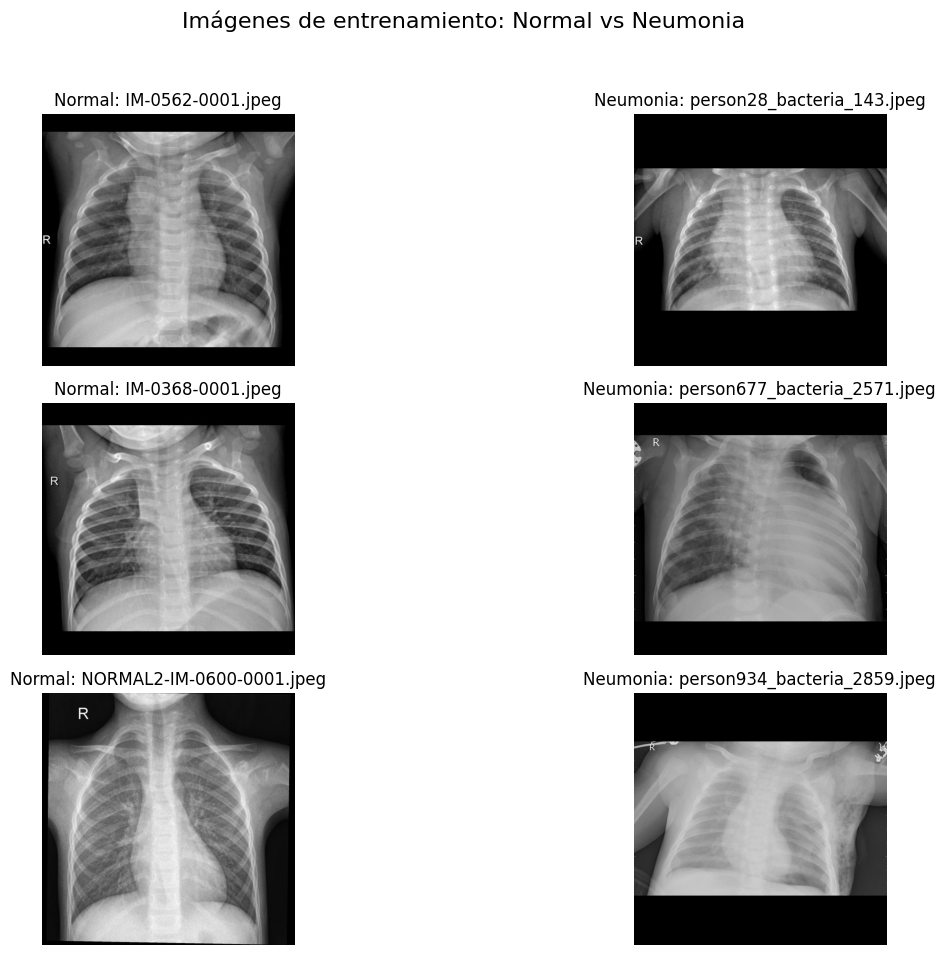

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
images = []
for i in range(3):
    # Imagen normal
    img_normal = plt.imread(os.path.join(train_normal, random_normal_images[i]))
    images.append(img_normal)
    axes[i, 0].imshow(img_normal, cmap='gray')
    axes[i, 0].set_title(f'Normal: {random_normal_images[i]}')
    axes[i, 0].axis('off')
    
    # Imagen con neumonia
    img_neumonia = plt.imread(os.path.join(train_pneumonia, random_neumonia_images[i]))
    images.append(img_neumonia)
    axes[i, 1].imshow(img_neumonia, cmap='gray')
    axes[i, 1].set_title(f'Neumonia: {random_neumonia_images[i]}')
    axes[i, 1].axis('off')
    
plt.suptitle('Imágenes de entrenamiento: Normal vs Neumonia', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


tamaño imagen normal: (512, 512)
tamaño imagen normal: (512, 512)
tamaño imagen normal: (512, 512)
tamaño imagen neumonía: (512, 512)
tamaño imagen neumonía: (512, 512)
tamaño imagen neumonía: (512, 512)
Tamaño descriptor HOG imagen 1: (142884,)
Tamaño descriptor HOG imagen 2: (142884,)
Tamaño descriptor HOG imagen 3: (142884,)
Tamaño descriptor HOG imagen 4: (142884,)
Tamaño descriptor HOG imagen 5: (142884,)
Tamaño descriptor HOG imagen 6: (142884,)


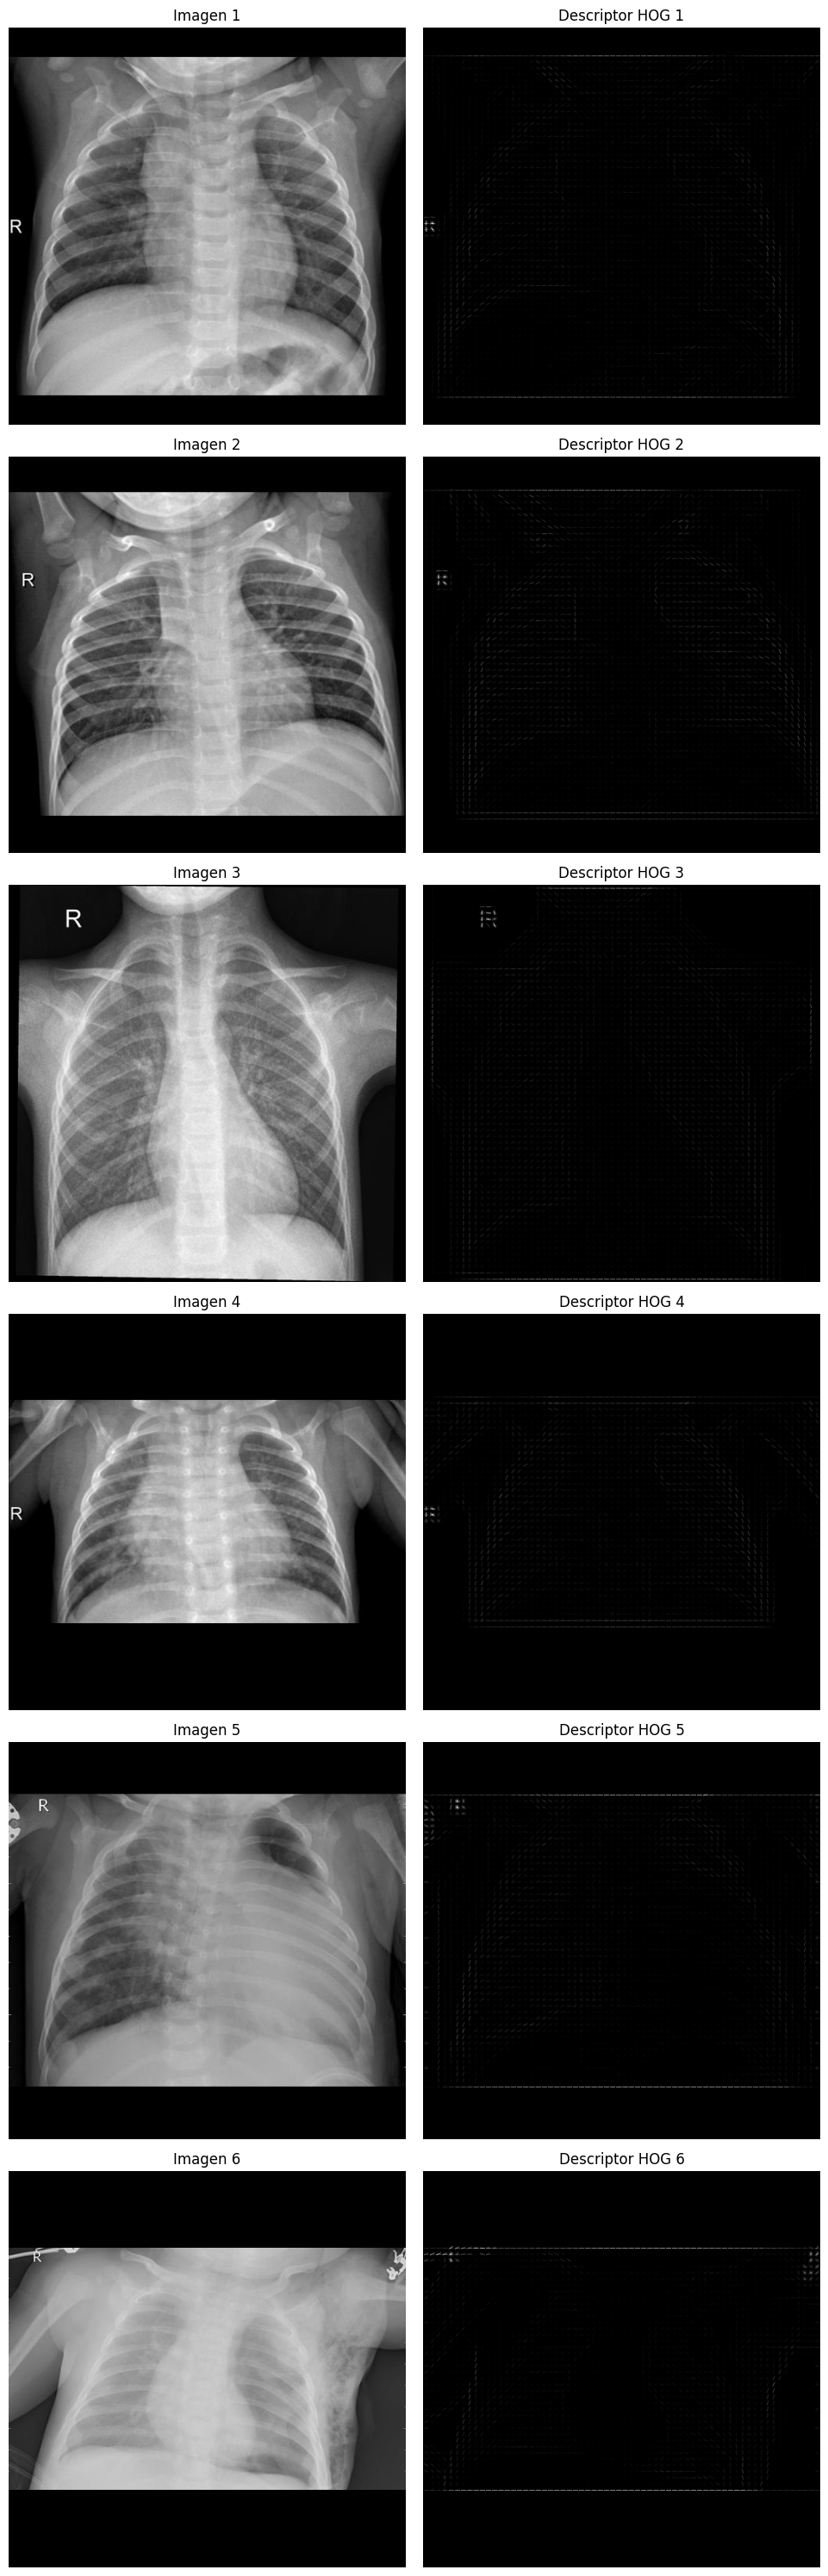

In [6]:
import random
import matplotlib.pyplot as plt
from skimage.feature import hog

# Obtener el conjunto de datos de entrenamiento como un iterable de Python y convertirlas a escala de grises
dataset = []
for img in random_normal_images:
    imagen = cv2.imread(os.path.join(train_normal, img))
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    print('tamaño imagen normal:', imagen.shape)
    dataset.append(imagen)
for img in random_neumonia_images:
    imagen = cv2.imread(os.path.join(train_pneumonia, img))
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    print('tamaño imagen neumonía:', imagen.shape)
    dataset.append(imagen)

# Crear la figura con 2 columnas (una para la imagen y otra para el descriptor)
num_images = len(dataset)
fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

for i, imagen in enumerate(dataset):
    # Mostrar la imagen original
    axes[i, 0].imshow(imagen, cmap='gray')
    axes[i, 0].set_title(f'Imagen {i + 1}')
    axes[i, 0].axis('off')

    # Verificar y ajustar las dimensiones de la imagen
    height, width = imagen.shape
    if height < 64 or width < 64:
        print(f"Imagen demasiado pequeña para HOG: {imagen.shape}")
        axes[i, 1].axis('off')  # Desactivar el eje del descriptor si no se puede calcular
        continue

    # Calcular el descriptor HOG y la imagen visualizada
    try:
        hog_features, hog_image = hog(
            imagen,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True,
            channel_axis=None
        )
    except Exception as e:
        print(f"Error al calcular HOG: {e}")
        axes[i, 1].axis('off')  # Desactivar el eje del descriptor si hay un error
        continue
    print(f'Tamaño descriptor HOG imagen {i + 1}:', hog_features.shape)
    # Mostrar el descriptor HOG visualizado
    axes[i, 1].imshow(hog_image, cmap='gray')
    axes[i, 1].set_title(f'Descriptor HOG {i + 1}')
    axes[i, 1].axis('off')

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()

## generarel descriptor HOG para el rest de las imágenes y guardar el resultado en un archivo .npy

In [8]:
# Función para procesar una sola imagen y calcular el descriptor HOG
def procesar_imagen(img_name, input_dir, hog_extractor):
    try:
        img_path = os.path.join(input_dir, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"No se pudo cargar la imagen: {img_name}")
        features = hog_extractor.compute(image)
        return features
    except Exception as e:
        print(f"Error procesando la imagen {img_name}: {e}")
        return None

# generar descriptores HOG para todas las imágenes en train, test y val y guardarlos en salida_caracteristicas
hog_extractor = HOG(cell_size=cell_size, block_size=block_size, block_stride=block_stride, nbins=num_bins)

# train normal
feactures_train_normal = []

# Usar ThreadPoolExecutor para paralelizar el procesamiento con un máximo de 12 hilos
with ThreadPoolExecutor(max_workers=2) as executor:
    futures = {executor.submit(procesar_imagen, img_name, train_normal, hog_extractor): img_name for img_name in os.listdir(train_normal)}
    for future in tqdm(futures, desc="Procesando imágenes de entrenamiento (NORMAL)"):
        result = future.result()
        if result is not None:
            feactures_train_normal.append(result)

# Convertir la lista de características a un array de NumPy
feactures_train_normal = np.array(feactures_train_normal)

# Guardar características en un archivo .npy
feature_path = os.path.join(salida_caracteristicas, 'hog_train_normal' + '.npy')
os.makedirs(os.path.dirname(feature_path), exist_ok=True)
np.save(feature_path, feactures_train_normal)

Procesando imágenes de entrenamiento (NORMAL):  14%|█▎        | 184/1341 [00:26<04:20,  4.45it/s]

: 

: 

In [ ]:
! jupyter.viewOutput

/usr/bin/sh: 1: jupyter.viewOutput: not found


## Bibliografía

- https://medium.com/@dnemutlu/hog-feature-descriptor-263313c3b40d